# Import Libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string , re
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Load Data

In [2]:
# read csv file into pandas
df = pd.read_csv("stu-answers.csv")
df.head(10)

,id_question,stu_answer,grade
0,18,ز,0
1,18,جبرائيل,1
2,18,جبريل,2
3,18,جبريل عليه السلام,2
4,18,سيدنا جبريل عليه السلام,2
5,18,جبريل عليه السلام\n,2
6,18,إسم الملك الذي جاء بالوحي إلى رسول الله صلى ال...,2
7,18,جبريل عليه السلام,2
8,18,جبريل عليه السلام,2
9,18,جبريل,2


# EDA

### Check Size of Data

In [4]:
print(f'Number of Rows : {df.shape[0]}')
print(f'Number of Columns : {df.shape[1]}')

Number of Rows : 1260
Number of Columns : 3


### Check Missing Values

In [5]:
df.isna().sum()

id_question     0
stu_answer     76
grade           0
dtype: int64

### Check Dublication

In [6]:
df.duplicated().sum()

385

## Visualize Target 

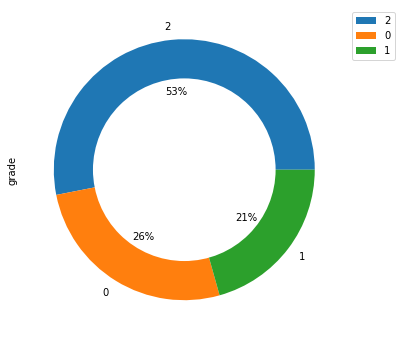

In [7]:
plt.figure(figsize=(10,6))
df['grade'].value_counts().plot.pie(autopct='%2.f%%')
center = plt.Circle((0,0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center)
plt.legend(bbox_to_anchor=(1,1),loc=2)
plt. show()

### Drop Unnecessary Columns

In [8]:
df.drop('id_question', axis=1, inplace=True)

### Drop Missing and Dublication Values

In [9]:
df.dropna(inplace=True)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
print(f'Number of Rows : {df.shape[0]}')
print(f'Number of Columns : {df.shape[1]}')

Number of Rows : 855
Number of Columns : 2


In [12]:
df.head()

,stu_answer,grade
0,ز,0
1,جبرائيل,1
2,جبريل,2
3,جبريل عليه السلام,2
4,سيدنا جبريل عليه السلام,2


In [13]:
#analyze the total length of each message
df['length'] = df['stu_answer'].apply(len)
df.head()

,stu_answer,grade,length
0,ز,0,1
1,جبرائيل,1,7
2,جبريل,2,5
3,جبريل عليه السلام,2,17
4,سيدنا جبريل عليه السلام,2,23


In [14]:
df['length'].max()

311

In [15]:
# print(stopwords.words('arabic'))

In [16]:
# print(string.punctuation)

# Pre-Preocessing

In [17]:
def txt_preprocess(text):
    
    stpword = stopwords.words('arabic')
    
    #check if there are any punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    #join the chars
    nopunc = ''.join(nopunc)
    
    #remove any stopwords
    clean_stopwords = [word for word in nopunc.split() if word not in stpword]
    clean_words = ""
    
    #stemming
    for x in clean_stopwords:
        stemmer = ISRIStemmer()
        clean_words += (stemmer.stem(x)) + " "
        
    return clean_words

In [18]:
df['answer_cleaned'] = df['stu_answer'].apply(txt_preprocess)

In [19]:
df.head(20)

,stu_answer,grade,length,answer_cleaned
0,ز,0,1,
1,جبرائيل,1,7,جبرائيل
2,جبريل,2,5,جبريل
3,جبريل عليه السلام,2,17,جبريل سلم
4,سيدنا جبريل عليه السلام,2,23,سيد جبريل سلم
5,جبريل عليه السلام\n,2,19,جبريل سلم
6,إسم الملك الذي جاء بالوحي إلى رسول الله صلى ال...,2,79,اسم ملك جاء وحي رسل الل صلى الل سلم جبريل سلم
19,سيدنا جبريل,2,11,سيد جبريل
20,جبريل عليه السلام\n,2,18,جبريل سلم
21,اسم الملك المكلف بالوحي هو جبريل عليه السلام,2,45,اسم ملك كلف وحي جبريل سلم


# Text Representation and Build Model

In [240]:
max_fatures = 300
max_len = 200
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['answer_cleaned'].values)
X = tokenizer.texts_to_sequences(df['answer_cleaned'].values)
X = pad_sequences(X ,max_len )

In [241]:
print(f'Number of Rows : {df.shape[0]}')
print(f'Number of Columns : {df.shape[1]}')

(855, 200)

In [242]:
y = df['grade']

In [266]:
embed_size = 128
model = Sequential()
model.add(Embedding(max_fatures, embed_size ,input_length = X.shape[1]))
model.add(LSTM(200, dropout=0.5, return_sequences=True))
model.add(LSTM(100, dropout=0.3))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])

In [267]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(684, 200)
(171, 200)


In [268]:
model.fit(X_train, Y_train, epochs = 15, batch_size = 64, verbose = 1)

Epoch 1/15
11/11 [==============================] - 22s 1s/step - loss: 1.0801 - accuracy: 0.4561
Epoch 2/15
11/11 [==============================] - 15s 1s/step - loss: 1.0589 - accuracy: 0.4605
Epoch 3/15
11/11 [==============================] - 17s 2s/step - loss: 1.0138 - accuracy: 0.4795
Epoch 4/15
11/11 [==============================] - 18s 2s/step - loss: 0.9580 - accuracy: 0.5058
Epoch 5/15
11/11 [==============================] - 22s 2s/step - loss: 0.8752 - accuracy: 0.5921
Epoch 6/15
11/11 [==============================] - 20s 2s/step - loss: 0.8038 - accuracy: 0.6491
Epoch 7/15
11/11 [==============================] - 16s 1s/step - loss: 0.7484 - accuracy: 0.6857
Epoch 8/15
11/11 [==============================] - 16s 1s/step - loss: 0.6408 - accuracy: 0.7485
Epoch 9/15
11/11 [==============================] - 16s 1s/step - loss: 0.5855 - accuracy: 0.7602
Epoch 10/15
11/11 [==============================] - 15s 1s/step - loss: 0.5705 - accuracy: 0.7749
Epoch 11/15
11/11 [

# Evaluate Model

In [270]:
loss , acc = model.evaluate(X_test, Y_test, verbose = 2)

6/6 - 2s - loss: 0.9795 - accuracy: 0.7076 - 2s/epoch - 329ms/step


In [271]:
loss

0.979489803314209

In [272]:
acc

0.707602322101593

# Test Model

In [297]:
i=1
while True:
    print("امتحان تربيه دينيه اسلاميه")
    ask = input(f"سؤال {i} : ")
    answer = input('الاجابه: ')
    i+=1
    process = txt_preprocess(answer)
    data = tokenizer.texts_to_sequences([process])
    test = pad_sequences(data, maxlen=320,  value=0)
    predicted_ques = model.predict(test)[0]

    labels=['Zero', 'One', 'Two']
    max_prob = np.argmax(predicted_ques)
    print(f'Grade of Answer Is : {labels[max_prob]}')
    
    exit = int(input("Enter Zero To Exit From System  OR One To Run The Program : \n"))
    if exit == 0:
        print('Exit From System...','Thank You')
        break
    else:
        continue   
        print('\n')


امتحان تربيه دينيه اسلاميه
سؤال 1 : كيف كانت الدعوة ؟
الاجابه: كانت سرا
1/1 [==============================] - 0s 74ms/step
Grade of Answer Is : Two
Enter Zero To Exit From System  OR One To Run The Program : 
1
امتحان تربيه دينيه اسلاميه
سؤال 2 : كيف كانت الدعوة ؟
الاجابه: 
1/1 [==============================] - 0s 189ms/step
Grade of Answer Is : Zero
Enter Zero To Exit From System  OR One To Run The Program : 
1
امتحان تربيه دينيه اسلاميه
سؤال 3 : كيف كانت الدعوة ؟
الاجابه: سريه
1/1 [==============================] - 0s 215ms/step
Grade of Answer Is : Zero
Enter Zero To Exit From System  OR One To Run The Program : 
1
امتحان تربيه دينيه اسلاميه
سؤال 4 : 
الاجابه: 
1/1 [==============================] - 0s 57ms/step
Grade of Answer Is : Zero
Enter Zero To Exit From System  OR One To Run The Program : 
1
امتحان تربيه دينيه اسلاميه
سؤال 5 : كيف كانت الدعوة؟
الاجابه: سررا
1/1 [==============================] - 0s 213ms/step
Grade of Answer Is : Zero
Enter Zero To Exit From System  OR One